# Importing data

In [ ]:
!gdown https://drive.google.com/uc?id=1P12YAYLOg8T7x7beOkHozaPFsBRTFz5w
!unzip GTZAN\ Dataset\ -\ Music\ Genre\ Classification.zip

# Importing Libraries

In [ ]:
import json
import os

import keras
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

#### Extract the Feature of audio i.e MFCCs and append the data in the dictionary which contain the type of music, MFCCs and the label for the type of music

In [ ]:
SAMPLE_RATE = 22050
DURATION = 30  # 30SEC
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    for i, (dirpath, dirname, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print(f"\n Processing {semantic_label}")

            num_samples_per_segent = int(SAMPLES_PER_TRACK / num_segments)
            expected_num_mfcc_vectos_per_segment = np.ceil((num_samples_per_segent / hop_length))

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                for s in range(num_segments):
                    start_sample = num_samples_per_segent * s
                    finish_sample = start_sample + num_samples_per_segent

                    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft=n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length

                                                )
                    mfcc = mfcc.T

                    if len(mfcc) == expected_num_mfcc_vectos_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
    return data

In [ ]:
DATASET_PATH = "/content/Data/genres_original"
JSON_PATH = "data.json"
data = save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


 Processing classical

 Processing reggae

 Processing jazz

 Processing country

 Processing disco

 Processing metal

 Processing hiphop

 Processing pop

 Processing rock

 Processing blues


In [ ]:
JSON_PATH = "data.json"
with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)

In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.tight_layout()
    plt.show()

# Dataset split for train, test, and validation.

In [ ]:
def prepare_dataset(test_size, validation_size):
    # load data
    X, y = load_data("/content/data.json")

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42,
    )

    # create train/validation split

    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train,
        y_train,
        test_size=validation_size,
        random_state=42,
    )

    # 3d array
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

# Build CNN model

In [ ]:
def build_cnn_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(.25, .2,)

Data succesfully loaded!


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    epochs=30
)

Epoch 1/30
188/188 [==============================] - 17s 80ms/step - loss: 2.3260 - accuracy: 0.2419 - val_loss: 1.9016 - val_accuracy: 0.3318
Epoch 2/30
188/188 [==============================] - 16s 82ms/step - loss: 1.8467 - accuracy: 0.3812 - val_loss: 1.5785 - val_accuracy: 0.4626
Epoch 3/30
188/188 [==============================] - 16s 87ms/step - loss: 1.6274 - accuracy: 0.4281 - val_loss: 1.4634 - val_accuracy: 0.4960
Epoch 4/30
188/188 [==============================] - 16s 86ms/step - loss: 1.4865 - accuracy: 0.4767 - val_loss: 1.3997 - val_accuracy: 0.5214
Epoch 5/30
188/188 [==============================] - 16s 86ms/step - loss: 1.4148 - accuracy: 0.4992 - val_loss: 1.3258 - val_accuracy: 0.5414
Epoch 6/30
188/188 [==============================] - 16s 87ms/step - loss: 1.3453 - accuracy: 0.5278 - val_loss: 1.2841 - val_accuracy: 0.5601
Epoch 7/30
188/188 [==============================] - 16s 83ms/step - loss: 1.2951 - accuracy: 0.5340 - val_loss: 1.2572 - val_accuracy:

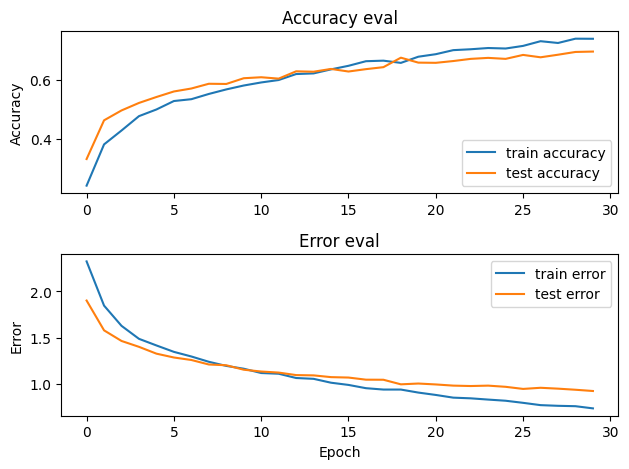

In [ ]:
plot_history(history)

In [ ]:
test_error, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"test_accuarcy: {test_accuracy}")

79/79 [==============================] - 1s 15ms/step - loss: 0.8127 - accuracy: 0.7221
test_accuarcy: 0.7220664620399475


# Prediction using the CNN model

In [ ]:
def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)  # X -> (130, 13, 1) requires -> (1, 130, 13 ,1)
    prediction_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}\n Predicted index:{prediction_index}")

In [ ]:
X = X_test[101]
y = y_test[101]
predict(cnn_model, X, y)

1/1 [==============================] - 0s 478ms/step
Expected index: 7
 Predicted index:[7]
